<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/99_Lite_%D0%98%D0%B7%D0%BC%D0%B5%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BA%D0%BE%D1%8D%D1%84_%D1%83%D1%87%D0%B5%D1%82%D0%B0_%D0%B1%D1%83%D0%B4%D1%83%D1%89%D0%B8%D1%85_%D0%BD%D0%B0%D0%B3%D1%80%D0%B0%D0%B4_Q_learning_(%D0%9D%D0%B0%D1%85%D0%BE%D0%B6%D0%B4%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BA%D1%80%D0%B0%D1%82%D1%87%D0%B0%D0%B9%D1%88%D0%B5%D0%B3%D0%BE_%D0%BF%D1%83%D1%82%D0%B8).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Lite

Макс 10 баллов

Проведите эксперименты с алгоритмом нахождения кратчайшего пути, изменяя параметры коэффициента учета будущих наград. Установите следующие значения:

1
0.75
И засеките время до того момента, когда бот впервые доберется до финишной позиции.

Сделайте вывод по получившимся результатам.
Разбор: Ноутбук: https://colab.research.google.com/drive/1I2SkPVvf4MzP-c-kTyv7FQw1LdTUj5Pa?usp=sharing

*Теоретический материал:* https://youtu.be/dth5h3XCwMI?t=24

*Разбор данного раздела:* https://youtu.be/dth5h3XCwMI?t=1600

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from IPython.display import clear_output
import time
sns.set_style('darkgrid')

In [ ]:
class Agent():
    def __init__(self):
        self.points = [-50, -1, 10]
        self.step = ([[-1, 0], # Влево
                      [0, 1], # Вверх
                      [1, 0], # Вправо
                      [0, -1]]) # Вниз
        self.kf_rewards = 0.99 # коэффициент учета будующих награждений 
        self.epsilon = 1.0 # параметр случайного хода
        self.rewards = np.zeros((5,13,4)) # матрица наград игрового поля    
        self.sleep = 0 # задержка перед следующим ходом
        self.start_position = np.array([1,0]) # стартовая позиция
        self.finish_position = np.array([10,0]) # финишная позиция
        self.rewards[self.start_position[1],self.start_position[0]] = self.points[0]+10 # Начальные награды в стартовой точнке
        
    # Функция создания игрового поля
    def createPole(self): 
        fig,ax = plt.subplots(1, figsize=(24,10)) # Создаем полотно
        rect = patches.Rectangle((0, 5),12,-5, linewidth=2, edgecolor='black') # Создаем прямоугольник вокруг всего игрового поля
        ax.add_patch(rect) # Рисуем прямоугльник
        rect = patches.Rectangle((1,1),1,-1,linewidth=1, edgecolor='black',facecolor='b', alpha=0.3) # Создаем прямоугльник стартовой позиции
        ax.add_patch(rect) # Рисуем прямоугльник        
        # Рисуем "опасные" прямоугольники по границе игрового поля
        for i in range(2,10):
            rect = patches.Rectangle((i,1),1,-1,linewidth=1, edgecolor='black',facecolor='r', alpha=0.5)
            ax.add_patch(rect)
        for i in range(1,12):
            rect = patches.Rectangle((i,5),1,-1,linewidth=1, edgecolor='black',facecolor='r', alpha=0.5)
            ax.add_patch(rect)
        for i in range(1, 6):
            rect = patches.Rectangle((0,i),1,-1,linewidth=1, edgecolor='black',facecolor='r', alpha=0.5)
            ax.add_patch(rect)
        for i in range(1, 5):
            rect = patches.Rectangle((11,i),1,-1,linewidth=1, edgecolor='black',facecolor='r', alpha=0.5)
            ax.add_patch(rect)        
        rect = patches.Rectangle((10,1),1,-1,linewidth=1, edgecolor='black',facecolor='g', alpha=0.4) # Создаем прямоугльник финишной позиции
        ax.add_patch(rect) # Рисуем прямоугльник
        plt.xticks(np.arange(13))
        plt.yticks(np.arange(6))
        return fig,ax
    
    # Функция получения случайного хода
    def GetNextRandomPosition(self, current_position, positions):        
        while True:
            idx = np.random.randint(4) # Генерируем случайное значение (0,1,2,3)
            next_position = current_position + self.step[idx] # Получаем новое положение
            
            # Если награда за движение в указанную точку не равна минимальное (означает, что двигаемся в "опасную" точку)
            if self.rewards[current_position[1], current_position[0], idx] != self.points[0]:
                # Если не вышли за границу игрового поля
                if next_position.min() >= 0 and next_position[1]<5 and next_position[0]<12:
                    # Если это не первый шаг
                    if len(positions)>1:
                        # Если не делаем шаг назад
                        if list(next_position) != positions[-2]:                            
                                return next_position
                    else:
                        return next_position

    # Функция: сыграть одну партию
    def playGame(self):
        clear_output(wait=True) # очищаем экран    
        current_position = self.start_position # Текущая позиция равна стартовой
        positions = [list(self.start_position)] # В список позиций записываем стартовую позицию
        while True:                
            f,a = self.createPole() # Создаем игровое поле
            # Генерируем случайное значение от 0 до 1. И если оно меньше текущего значения self.epsilon
            if np.random.random()<self.epsilon:
                # Делаем случайный шаг
                next_position = self.GetNextRandomPosition(current_position, positions)
            # В противном случае
            else:                
                re = np.argmax(self.rewards[current_position[1], current_position[0]]) # Получаем максимальное вознаграждение из текущей позиции
                next_position = current_position + self.step[re] # Делаем шаг по пути максимального вознаграждения
                # Если вышли за пределы игрового поля
                if next_position.min() < 0 or next_position[1]>4 or next_position[0]>11:
                    # то перезаписываем новое положение на случайное
                    next_position = self.GetNextRandomPosition(current_position, positions)                    
                # Если это не первый шаг
                if len(positions)>1:
                    # Если сделали шаг назад
                    if list(next_position) == positions[-2]:
                        # Перезаписываем новое положение на случайное
                        next_position = self.GetNextRandomPosition(current_position, positions)
            # Если self.epsilon больше 0.05
            if self.epsilon>0.05:
                self.epsilon *= 0.999 # Изменяем значение            
            positions.append(list(next_position)) # Добавляем в список позиций новое положение агента
            # Визуализируем путь игрока желтыми линиями
            for p in range(len(positions)-2):
                x = [positions[p][0]+0.5, positions[p+1][0] +0.5]
                y = [positions[p][1]+0.5, positions[p+1][1] +0.5]
                a.plot(x, y, marker = 'o', color = 'y', linewidth=4)            
            # Последний шаг рисуем оранжевой линией
            x = [positions[-2][0]+0.5, positions[-1][0] +0.5]
            y = [positions[-2][1]+0.5, positions[-2][1] +0.5]
            a.plot(x, y, marker = 'o', color = 'g', linewidth=4)
            
            # Печатаем текстовую информацию (награды в каждой ячейке игрового поля)
            for i in range(5):
                for j in range(12):
                    txt = 'Left:'+str(round(self.rewards[i,j,0],2))+'\n'+\
                            'Up:'+str(round(self.rewards[i,j,1],2))+'\n'+\
                            'Right:'+str(round(self.rewards[i,j,2],2))+'\n'+\
                            'Down:'+str(round(self.rewards[i,j,3],2))                
                    a.text(j+0.1, i+0.2, txt, fontsize=16, alpha = 0.7) 
            plt.show()
            
            current_position = next_position # Перезаписываем текущее положение
            clear_output(wait=True) # Очищаем экран
            
            # Если попали в "опасную" точку или дошли до финиша
            if next_position[1] == 0 or next_position[1] == 4 or next_position[0] == 0 or next_position[0] == 11:
                break # Выходим из цикла
            time.sleep(self.sleep) # Пауза после завершения партии      
        return positions # Возврщаем список позиций
    
    def bestPath(self):
        clear_output(wait=True)        
        current_position = self.start_position
        positions = [list(self.start_position)]
        while True:
            f,a = self.createPole()
            re = np.argmax(self.rewards[current_position[1], current_position[0]])                
            next_position = current_position + self.step[re]
            positions.append(list(next_position))
            for p in range(len(positions)-1):
                x = [positions[p][0]+0.5, positions[p+1][0] +0.5]
                y = [positions[p][1]+0.5, positions[p+1][1] +0.5]
                a.plot(x, y, marker = 'o', color = 'y', linewidth=4)  
                x = [positions[-2][0]+0.5, positions[-1][0] +0.5]
                y = [positions[-2][1]+0.5, positions[-2][1] +0.5]
                a.plot(x, y, marker = 'o', color = 'g', linewidth=4)
            for i in range(5):
                for j in range(12):
                    txt = 'Left:'+str(round(self.rewards[i,j,0],2))+'\n'+\
                            'Up:'+str(round(self.rewards[i,j,1],2))+'\n'+\
                            'Right:'+str(round(self.rewards[i,j,2],2))+'\n'+\
                            'Down:'+str(round(self.rewards[i,j,3],2))                
                    a.text(j+0.1, i+0.2, txt, fontsize=16, alpha = 0.7) 
            plt.show()
            current_position = next_position
            clear_output(wait=True) 
            if next_position[1] == 0 or next_position[1] == 4 or next_position[0] == 0 or next_position[0] == 11:
                break   
    
    
    def train(self, count=20, auto = True):
        for _ in range(count):            
            positions = self.playGame()
            f,a = self.createPole()
            
            for p in range(len(positions)-1):
                    x = [positions[p][0]+0.5, positions[p+1][0] +0.5]
                    y = [positions[p][1]+0.5, positions[p+1][1] +0.5]
                    a.plot(x, y, marker = 'o', color = 'y', linewidth=4)
            
            action = self.step.index(list(np.array(positions[-1]) - np.array(positions[-2])))
            rew = self.points[0]
            if positions[-1] == list(self.finish_position):
                rew = self.points[2]
            self.rewards[positions[-2][1],positions[-2][0]][action] = rew
            y = 0.75 # коэффициент эффективности будущих наград изменяем на 0,75 !!!!! надо было поменять agent.kf_rewards = 0.75 
            if len(positions)>2:
                for i in range(len(positions)-3,-1, -1):
                    action = self.step.index(list(np.array(positions[i+1]) - np.array(positions[i])))
                    self.rewards[positions[i][1],positions[i][0]][action] = self.points[1] + y * max(self.rewards[positions[i+1][1],positions[i+1][0]]) 
                    # y *= self.kf_rewards 
            for i in range(5):
                for j in range(12):
                    txt = 'Left:'+str(round(self.rewards[i,j,0],2))+'\n'+\
                            'Up:'+str(round(self.rewards[i,j,1],2))+'\n'+\
                            'Right:'+str(round(self.rewards[i,j,2],2))+'\n'+\
                            'Down:'+str(round(self.rewards[i,j,3],2))                
                    a.text(j+0.1, i+0.2, txt, fontsize=16, alpha = 0.7)            
            plt.show()
            if positions[-1] == list(self.finish_position):
              break

In [ ]:
agent = Agent()

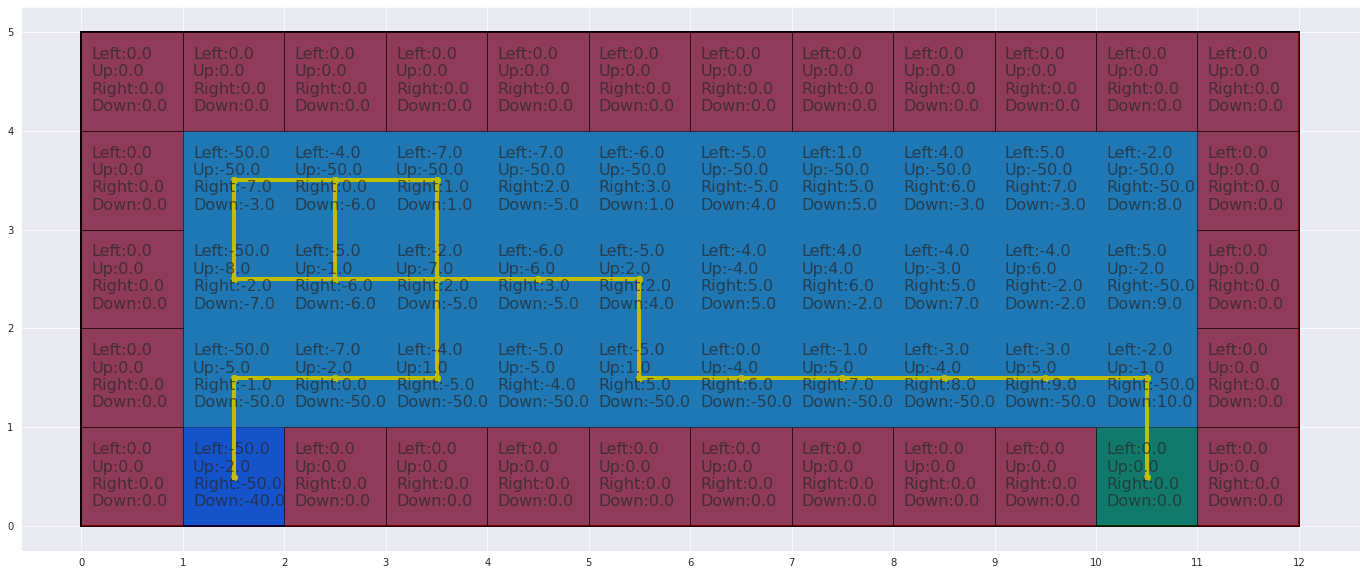

y =  1
Игра  0 заняла  812.04 c
Игра  1 заняла  18.01 c
Игра  2 заняла  15.33 c
Игра  3 заняла  12.56 c
Игра  4 заняла  16.45 c


In [ ]:
# Результат затраченного времени на поиск кратчайшего пути при коэффициенте будущих наград = 1
total_time = []
y = 1

for i in range(5):  
  start_time = time.time()
  position = agent.train(50)
  t = round(time.time() - start_time, 2)
  total_time.append(t)

print("y = ", y)
for t in range(5):      
  print("Игра ", t, "заняла ", total_time[t], "c")


In [ ]:
agent = Agent()

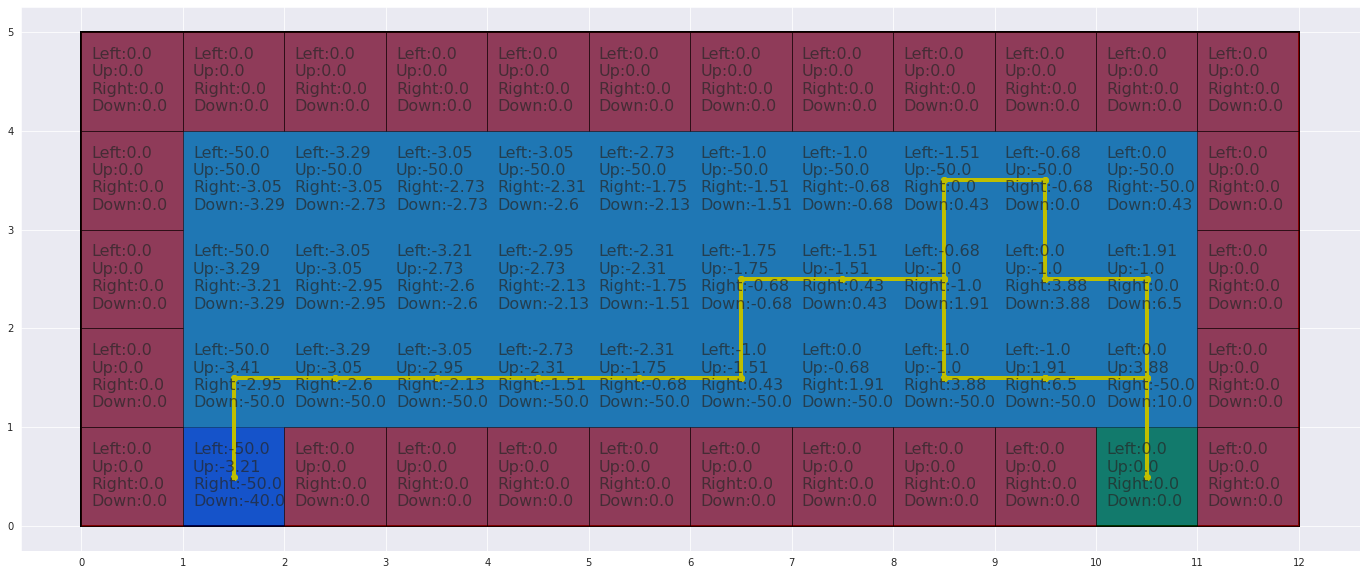

y =  0.75
Игра  0 заняла  215.28 c
Игра  1 заняла  72.45 c
Игра  2 заняла  18.0 c
Игра  3 заняла  49.16 c
Игра  4 заняла  46.56 c


In [ ]:
# Результат затраченного времени на поиск кратчайшего пути при коэффициенте будущих наград = 0.75
total_time = []
y = 0.75

for i in range(5):  
  start_time = time.time()
  position = agent.train(50)
  t = round(time.time() - start_time, 2)
  total_time.append(t)

print("y = ", y)
for t in range(5):      
  print("Игра ", t, "заняла ", total_time[t], "c")

Вывод: Для исследования были использованы значения коэффициента эффективности наград равные 1 и 0,75. При этом была отключена опция постепенного снижения данного значения. Т.е. коэффициенты были константными. В результате при y =  0.75 время, затраченное на поиск кратчайшего пути, оказалось в 4 раза меньше, чем при y =  1.

Мы выяснили, что при  у = 1 будущие награды будут иметь такой же эффект, как и текущие. И наоборот, если поставить значние у = 0,75 , таким образом можно уменьшить эффект будущих наград. 

Если рандомное значение выше коэффициента будущих наград, значит мы выбираем из 4 значений действие, которое принесет максимальную награду. Соот-но, чем ниже коэффициент, тем меньше рандомности в выборе действий, больше доверия к выбору среди 4-х значениям будущих наград.
